# Churn Case Study
_The legacy of Bonnie Shen, Danielle Saunders, Jan Unel, and Eric Bragas_

## Problem Statement
A ride-sharing company is interested in predicting rider churn using a series of rider rating and behavior features. We'll explore this data, formulating questions to answer during the analysis, and provide a model to enable prediction of future rider churn events as well as infer the underlying characteristics that contribute to churn events. The business goal will then be to identify those likely to churn and take mitigating action either to company policy, or via targeted marketing. We'll see what the data tells us!

This workbook will leverage the data pipelining abilities of `sklearn` to better enable a fast and consistent modeling process without exposing potential leakage. See the accompanying `pipeline.py` file for custom pipeline transformer definitions.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

## Loading Data and Deriving the Target

The following pipeline will accept raw dataset and perform only the operations necessary to create the `churned` (target) field in our DataFrame. A second pipeline will be used later to perform addition feature transformations before training the model.

We chose to break these operations up into separate pipelines because the second pipeline will also contain an estimator class which will both trained and used to make predictions. Here, we just want to derive the target feature so it can be viewed and separated before training. Transformations at this step include:
* Setting data types of features required to derive the target variable
* Deriving features as steps towards creating the target e.g. calculating date differences
* Filtering the whole data set if necessary

In [9]:
from sklearn.pipeline import Pipeline
from src.pipeline import SetDataTypesTransformer
from src.pipeline import GenPredictorTransformer

Load and inspect the raw training data.

In [10]:
all_data = pd.read_csv('data/churn_train.csv')
all_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


Derive the target feature using our pipeline and inspect the results.

The most important things to note are the new `churned`, `inactive_timedelta`, `inactive_days`, and `today_dt` fields.

In [11]:
target_pipe = Pipeline([
    ('SetDataTypes', SetDataTypesTransformer()),
    ('GenPredictor', GenPredictorTransformer())
])

all_data_target = target_pipe.fit_transform(all_data)
all_data_target.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_trip_dt,signup_dt,today_dt,inactive_timedelta,inactive_days,churned
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,0,100.0,2014-05-03,2014-01-12,2014-07-01,59 days,59,1.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,1,0.0,2014-01-26,2014-01-25,2014-07-01,156 days,156,1.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,1,100.0,2014-05-21,2014-01-02,2014-07-01,41 days,41,1.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,0,100.0,2014-01-10,2014-01-09,2014-07-01,172 days,172,1.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,0,100.0,2014-05-13,2014-01-31,2014-07-01,49 days,49,1.0


Quick check of distribution of target class:

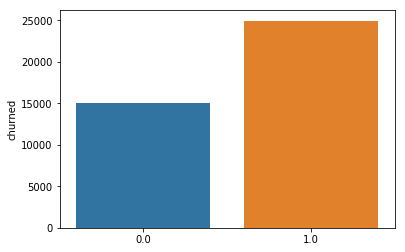

In [12]:
counts = all_data_target['churned'].value_counts()
sn.barplot(counts.index, counts);

The distribution of target classes isn't even, but it isn't so skewed that we need to use oversampling to compensate.

# Feature Cleaning and Model Tuning

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

from src.pipeline import FillTransformer
from src.pipeline import OneHotTransformer
from src.pipeline import SelectFeaturesTransformer
from src.pipeline import DeriveFeaturesTransformer
from src.pipeline import one_hot

Reload the training data and derive the target again:

In [14]:
train = pd.read_csv('data/churn_train.csv')
train = target_pipe.transform(train)

This pipeline will take the full data set we've created and perform all the data cleansing and feature selection required before training and testing our model. But first, we'll perform a train-test split.

In [15]:
y = train['churned'].copy()
X = train.copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=916)

> **Note:** we don't have to worry about feature selection here as this will be handled in the pipeline

## Create Pipeline

First, here is a sample of the uncleaned data.

**Note:** the number and names of features included, `NaN` values some of the features, and categorical features containing text values.

In [16]:
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_trip_dt,signup_dt,today_dt,inactive_timedelta,inactive_days,churned
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,0,100.0,2014-05-03,2014-01-12,2014-07-01,59 days,59,1.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,1,0.0,2014-01-26,2014-01-25,2014-07-01,156 days,156,1.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,1,100.0,2014-05-21,2014-01-02,2014-07-01,41 days,41,1.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,0,100.0,2014-01-10,2014-01-09,2014-07-01,172 days,172,1.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,0,100.0,2014-05-13,2014-01-31,2014-07-01,49 days,49,1.0


Create a pipeline for feature cleaning only:

In [17]:
cleaning_pipe = Pipeline([
    ('SelectFeats', SelectFeaturesTransformer()), 
    ('FillFeats', FillTransformer()),
    ('OneHot', OneHotTransformer()),
    ('DeriveFeats', DeriveFeaturesTransformer()),
])

Sample of the cleaned dataset.

**Note:** the reduced feature count, the imputed values in place of `NaN`, and the encoded dummy variables in place of our old categorical variables e.g. cities.

In [18]:
cleaning_pipe.fit_transform(X).head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,astapor,king's landing,android,always_surge_users
0,6.94,5.0,5.0,1.00,0.0,0,0,100.0,1,0,1,0.0
1,8.06,5.0,5.0,1.00,0.0,2,1,0.0,1,0,1,0.0
2,21.50,4.0,-1.0,1.00,0.0,1,1,100.0,0,0,0,0.0
3,9.46,5.0,-1.0,2.75,100.0,1,0,100.0,0,0,1,1.0
4,13.77,5.0,-1.0,1.00,0.0,0,0,100.0,0,0,0,0.0


Finally, create a full feature transformation and estimation pipeline which we'll actually use for cleaning and predicting values.

In [19]:
pipe = Pipeline([
    ('SelectFeats', SelectFeaturesTransformer()),
    ('FillFeats', FillTransformer()),
    ('OneHot', OneHotTransformer()),
    ('DeriveFeats', DeriveFeaturesTransformer()),
    ('XGBoostClass', XGBClassifier())  # final step is our estimator
])

## Grid Search
Here, we grid search over the all the possible combintations of provided hyper-parameters to try and identify the best combination of parameters for our scoring metric.

**Model hyper-parameters:**
* `max_depth` - the maximum depth of each decision tree estimator in the ensemble. These values are kept low as each tree should be a slow learner that can be aggregated later
* `n_estimators` - the number of decision tree estimators to evaluate in this ensemble model
* `learning_rate` - a tuning value to adjust the degree to which subsequent estimators in the ensemble are tuned to the error of the previous model. A lower learning rate typically results in higher accuracy, but requires more iterations

**Grid Search parameters:**
* `pipe` - the estimator to search over; in this case it's our pipeline
* `param_grid` - the hyper-parameter values to grid search over
* `cv` - the number of cross-validations to perform on each model + hyper-parameter combination
* `n_jobs` - enables parallelization

In [20]:
# Hyper-parameters
params = {'XGBoostClass__max_depth': [3],
          'XGBoostClass__n_estimators': [100, 500, 1000],
          'XGBoostClass__learning_rate': [1, 0.1, 0.03, 0.001]}

# Grid Search
gscv = GridSearchCV(pipe, 
                    param_grid=params,
                    cv=10,
                    n_jobs=-1
                   )

# Perform grid search, then make predictions using best model
clf = gscv.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Scoring:

In [21]:
print('Best params: {}\n'.format(clf.best_params_))

print(classification_report(y_test, y_pred))
print('\nAccuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Best params: {'XGBoostClass__learning_rate': 0.1, 'XGBoostClass__max_depth': 3, 'XGBoostClass__n_estimators': 500}

              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72      4996
         1.0       0.82      0.87      0.84      8204

   micro avg       0.80      0.80      0.80     13200
   macro avg       0.79      0.77      0.78     13200
weighted avg       0.80      0.80      0.80     13200


Accuracy Score: 0.80


## Train and Test Final Model
After the best model and hyper-parameters have been selected and cross-validated, we'll create a new instance of that model and train it on all of our available training data. This is one of the final steps in our training process and allows us to take advantage of all the training data we have available before performing a final test against our test set.

In [22]:
p_xgb = Pipeline([
    ('SelectFeats', SelectFeaturesTransformer()),
    ('FillFeats', FillTransformer()),
    ('DeriveFeats', DeriveFeaturesTransformer()),
    ('OneHot', OneHotTransformer()),
    ('XGBoostClass', XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.1))
])

xgb_final = p_xgb.fit(X, y)

Measure model performance using the held-out test set

In [23]:
# Load and prepare test data
test = pd.read_csv('data/churn_test.csv')
test = target_pipe.transform(test)

# Move into pipeline
test_y = test['churned'].copy()
test_X = test.copy()

# Model predictions
y_pred = p_xgb.predict(test_X)
y_prob = p_xgb.predict_proba(test_X)[:, 1]  # take probabilities of pos. class only

# Find accuracy of hold-out test
print(classification_report(test_y, y_pred))
print('\nAccuracy Score: {:.2f}'.format(accuracy_score(test_y, y_pred)))

              precision    recall  f1-score   support

         0.0       0.74      0.66      0.70      3772
         1.0       0.81      0.86      0.83      6228

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000


Accuracy Score: 0.78


## Assessing Model Performance

Choosing the best scoring metric for the business case is crucially important. When evaluating a binary classification model (such as this one) where the costs of predictions such as **True Positives vs. False Negatives** can have significantly different costs, it's important to optimize for the metric that will have the greatest cost to benefit ratio.

In our case, the cost of losing a customer because we incorrectly predicted wouldn't churn (False Negative) is significantly greater than the cost of incorrectly predicting they would churn and taking some mitigating action, such as a targeted promotion.

*How big is that cost?* That will require a dicussion with the business to formalize those costs, but here we'll make some estimations so that we can generate a cost-benefit analysis useful for tuning our model "sensitivity", known as the threshold.

But first! Let's evaluate basic model performance.

### ROC Curve and AUC

In [24]:
from sklearn.metrics import auc, roc_curve
from src.pipeline import plot_roc

The ROC Curve shows the rate of the model false positive by true positive predictions over a range of threshold values, from 0 to 1. Here, it is used to quantify the predicitve power of this model using the characteristic statistic, AUC (Area Under the Curve).

**Additional info:** [ROC Curves](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

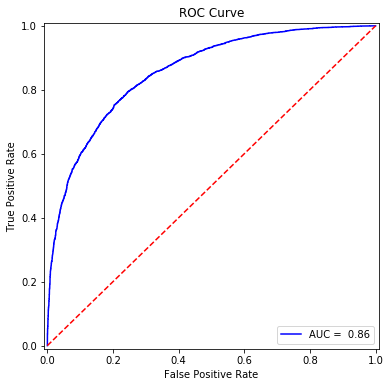

In [25]:
# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true=test_y, y_score=y_prob)
auc_score = auc(fpr, tpr)

plot_roc(fpr, tpr, auc_score)

This ROC and AUC show a rather even ability for the model to differntiate the two predicted classes with 86% probability.

While these results are well within the threshold of signifigance for predictive power, we'll try to improve them though further model tuning.

### Profit Curve

In [26]:
from sklearn.metrics import confusion_matrix

Define a cost benefit matrix
Multiply it with confusion matrix

Optimize model treshold
Find the treshold that maximizes profit

treshold for probability of positive.

In terms of defining the cost benefit matrix, we have no model and as a result we predict negative
because we are not capable to identify churn without a model.

Assumptions:
* CV for 6 months -- > $ 250 / customer

* Mitigating action(sending promotional coupons and calls) -- > -$ 200 / customer

* Incorrectly predicting that a customer will churn and sending a coupon may annoy them and cause them to 

churn 4 months early --> probablity of 0.05

In [27]:
#                     tp fn      fp tn
cost_mat = np.array([[250, 0], [-60, 0]])
cost_mat

#huge mistake here tp actually = 250 - 200 because we react positive predictions

array([[250,   0],
       [-60,   0]])

In [28]:
treshholds = np.linspace(0,1,100)

In [29]:
expected_total_profit = []
for t in treshholds:
    predictions = (y_prob > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
    conf_mat = np.array([[tp, fn], [fp, tn]])
    expected_total_profit.append((conf_mat * cost_mat).sum())


In [30]:
maximum_expected_profit_index = np.argsort(np.array(expected_total_profit))[-1]

In [31]:
maximum_expected_profit_index


20

In [32]:
expected_total_profit[maximum_expected_profit_index]

1368330

tn, fp, fn, tp

In [33]:
tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
conf_mat = np.array([[tp, fn], [fp, tn]])
conf_mat

array([[5355,  873],
       [1290, 2482]])

Lets see how the expected profit changes over increasing tresholds.

Treshold that gives the highest expected profit:0.20202020202020204


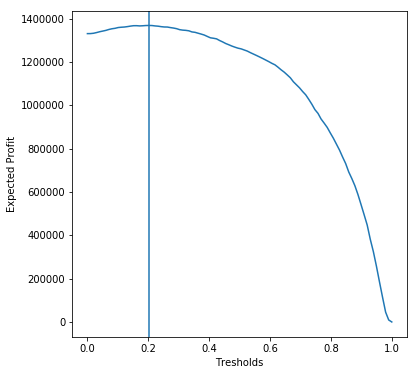

In [34]:
plt.figure(figsize=(6,6))
plt.plot(treshholds, expected_total_profit, label='XGBoost Classifier')
plt.xlabel('Tresholds')
plt.ylabel('Expected Profit')
plt.axvline(treshholds[maximum_expected_profit_index])
print(f'Treshold that gives the highest expected profit:{treshholds[maximum_expected_profit_index]}')

By varying the threshold, the model says "let's classify every customer with a score above the threshold as a 'churner' and everyone below it as a 'non-churner", then profit is calculated for each treshold. 

In [52]:
(y_prob > 0.202).mean()

0.8613

## Finding Feature Importance

(seaborn)

In [35]:
from seaborn import barplot
from sklearn.metrics import roc_curve, auc

Find feature importances

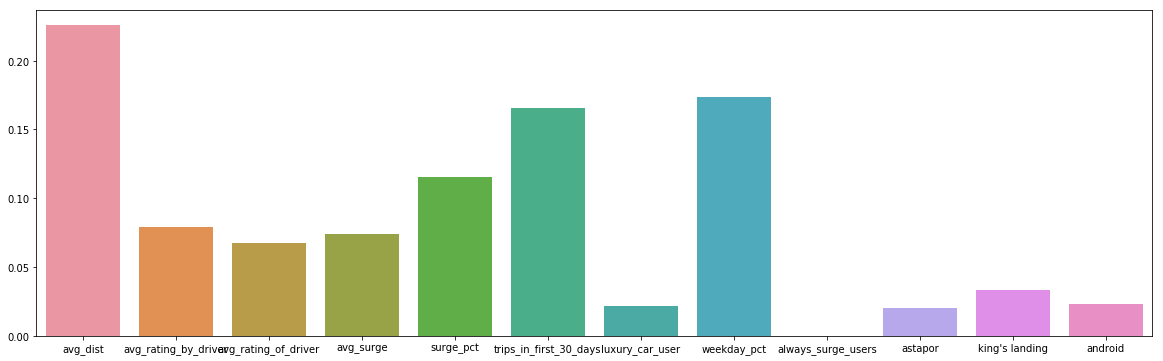

In [40]:
feat_imps = p_xgb.named_steps['XGBoostClass'].feature_importances_
feats = p_xgb.named_steps['OneHot'].train_columns

plt.figure(figsize=(20,6))
barplot(data=pd.DataFrame([feat_imps], columns=feats));

...

Weekday percentage presents high importance in accordance to the graph in hand.
On the other hand its consiredably high feature importance may be due to customers who used the service only once. 

Note: Followup and find ways to identify those users who used the service only once(because we should not consider that as churn). 

Additional information about finding feature importances of the model:
This methadology shows solid evidence of which features matter more to predict our target.
Yet it does not present any insights about the direction of the feature importance.
In other words we are not informed whether the correlation between avg_distance and probability of
churn is positive or negative. 

***note2: write short analisis about other features too and consider to position this part at EDA***